# Assessment for CASA0002 – Urban Simulation

https://github.com/ruicixia1/simulation

## Part 1: London’s underground resilience

### I. Topological network

#### I.1. Centrality measures:

In [1]:
# we will import all the necessary libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

C:\Users\lenovo\AppData\Local\Temp\ipykernel_38124\2494671397.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


 Degree centrality, betweenness centrality and eigenvector centrality are the three most useful measures for identifying the most important nodes in the underground networks.

1. **Degree Centrality**: Measures the number of direct connections a node has and is useful for indicating the local importance of a node (Bloch, Jackson, and Tebaldi, 2019). Stations with high degree centrality are crucial as they serve as major hubs, connecting various lines and facilitating a high number of passenger movement volumns across the network. A station with high degree centrality can significantly impact the network's functionality if removed or disrupted.  ($deg(v)$ is the degree of vertex $v$, and $N$ is the  total number of vertices in the graph)

$$C_D(v) = \frac{deg(v)}{N-1}$$ 
    


2. **Betweenness Centrality**: Quantifies the number of times a node
    acts as a bridge along the shortest path between two other nodes (Freeman, 1977).
    In the context of the underground, stations with high betweenness
    centrality are critical for maintaining network efficiency. They
    often serve as essential transfer points, and their removal could isolate network segments and increase travel times dramatically. ($σ {st}$ is the total number of shortest paths from node $s$ to node $t$ and $σ st(v)$ is the number of those paths that pass through $v$ .)
    
    $$C_B(v) = \sum_{s \neq v \neq t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}$$
    Normalised:
    $$C_B(v) = \frac{2}{(n-1)(n-2)} C_B(v)$$


3. **Eigenvector Centrality**: This measure not only considers the number of connections a station has but also the quality of those connections (Bonacich, 1987). A station connected to other highly connected stations has higher eigenvector centrality. This is crucial for identifying influential stations within the network, highlighting nodes that, while they may not have the highest number of direct connections, are strategically positioned.
$$C_{E}(v) = \frac{1}{\lambda} \sum_{t \in M(v)} C_{E}(t)$$
$$\mathbf{Ax} = \lambda \mathbf{x}$$



In [2]:
G = nx.read_graphml('london_updated.graphml')

In [3]:
for node, data in G.nodes(data=True):
    # convert the string to a tuple
    coords_str = data['coords'].strip("()")  
    # add the new key to the dictionary
    data['coords'] = tuple(map(float, coords_str.split(',')))

In [4]:
# check
is_connected = nx.is_connected(G)
print(f"Graph is connected：{is_connected}")

Graph is connected：True


In [5]:
# To check node attributes:
#G.nodes(data=True)

In [6]:
# To check edge attributes:
#G.edges(data=True)

In [7]:
print(G.number_of_nodes())
print(G.number_of_edges())

401
467


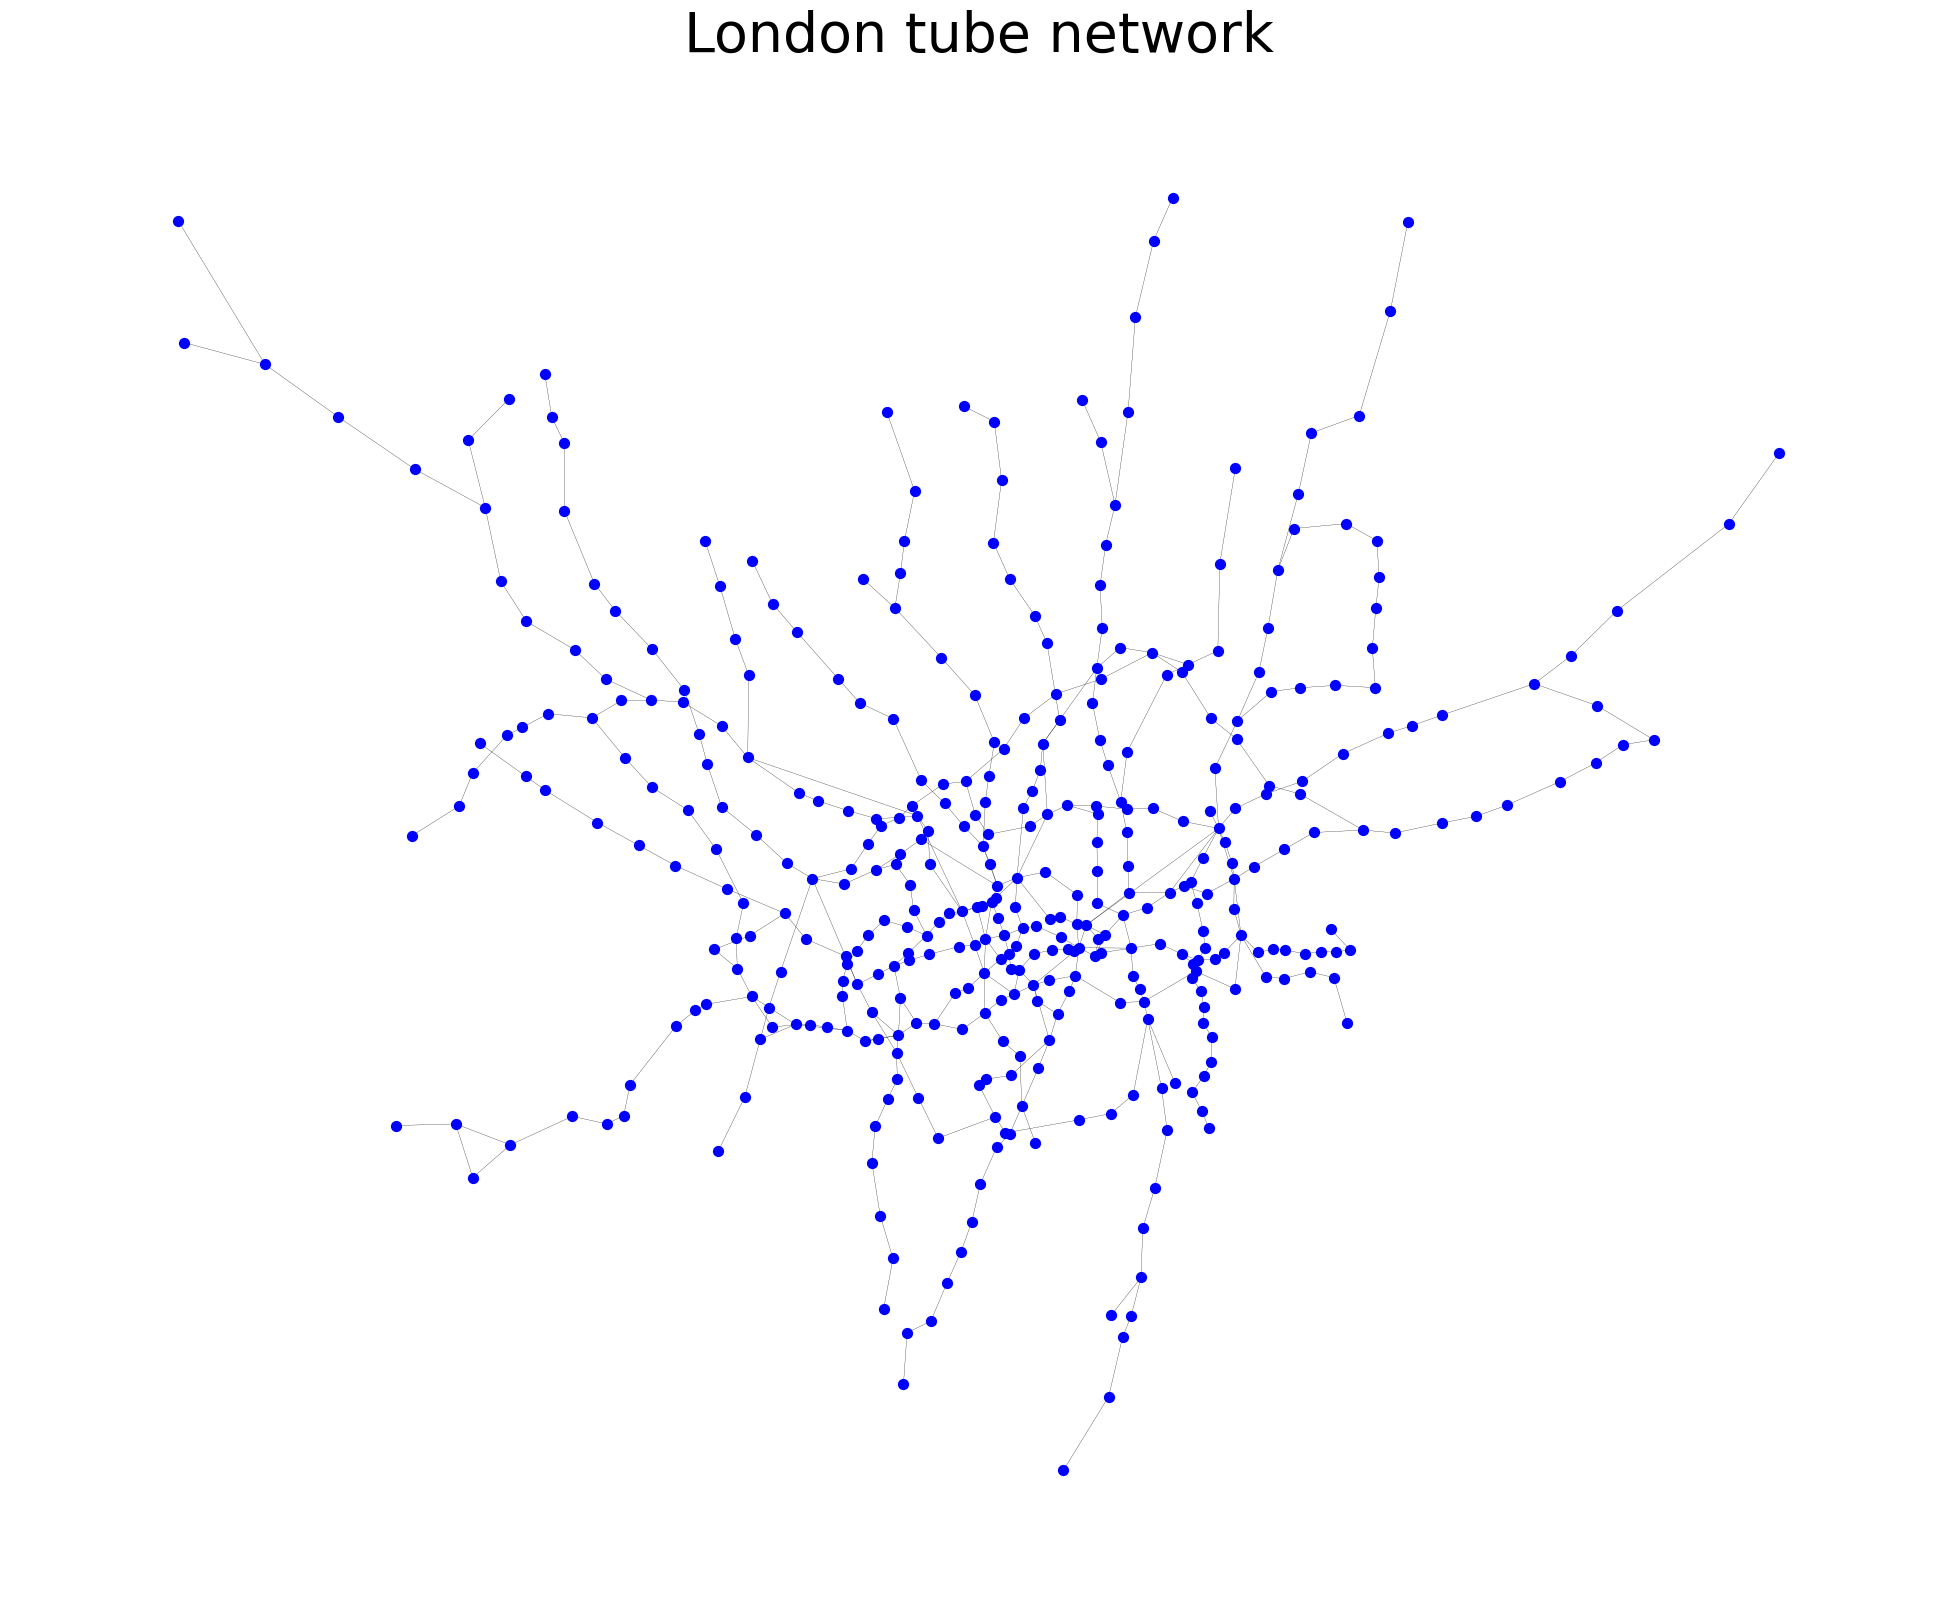

In [8]:
# Let's plot the tube network! 

# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(25,20))

node_labels = nx.get_node_attributes(G, 'station_name')

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=40)
plt.axis("off")
plt.show()

**Figure 1. London Tube Network**

In [9]:
# Compute centralities
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Sorting and selecting top 10
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create DataFrame from sorted lists
combined_df = pd.DataFrame({
    'Rank': range(1, 11),
    'Degree Centrality Station': [x[0] for x in sorted_degree],
    'Degree Centrality Value': [x[1] for x in sorted_degree],
    'Betweenness Centrality Station': [x[0] for x in sorted_betweenness],
    'Betweenness Centrality Value': [x[1] for x in sorted_betweenness],
    'Eigenvector Centrality Station': [x[0] for x in sorted_eigenvector],
    'Eigenvector Centrality Value': [x[1] for x in sorted_eigenvector]
}).set_index('Rank')

# Display the DataFrame
display(combined_df)


,Degree Centrality Station,Degree Centrality Value,Betweenness Centrality Station,Betweenness Centrality Value,Eigenvector Centrality Station,Eigenvector Centrality Value
Rank,,,,,,
1,Stratford,0.0225,Stratford,0.297846,Bank and Monument,0.383725
2,Bank and Monument,0.0200,Bank and Monument,0.290489,Liverpool Street,0.329191
3,Baker Street,0.0175,Liverpool Street,0.270807,Stratford,0.269574
4,King's Cross St. Pancras,0.0175,King's Cross St. Pancras,0.255307,Waterloo,0.249708
5,Liverpool Street,0.0150,Waterloo,0.243921,Moorgate,0.215343
6,West Ham,0.0150,Green Park,0.215835,Green Park,0.197023
7,Canning Town,0.0150,Euston,0.208324,Oxford Circus,0.183441
8,Waterloo,0.0150,Westminster,0.203335,Tower Hill,0.171839
9,Green Park,0.0150,Baker Street,0.191568,Westminster,0.168368


**Table 1. The first 10 ranked nodes for degree centrality, betweenness centrality and eigenvector centrality**

#### I.2. Impact measures:

Two global measures to evaluate the impact of node removal on the network are:

1. **Global Efficiency**($\text{Mean Inverse Shortest Path Length} (\langle l^{-1} \rangle)$):
This measure provides a way of measuring the overall efficiency of the network by considering the inversed average shortest path length between all pairs of nodes in the network (Latora & Massimo, 2001). For the London Underground network, this means being able to assess the average number of stops a passenger needs to make to get from one stop to another across the network. A high average reverse shortest path length indicates that passengers can reach their destination with fewer transfers or they are use other routes when facing station interruptions, reflecting the high efficiency of the network.

$$\langle l^{-1} \rangle = \frac{1}{N(N-1)} \sum_{j \in V} \sum_{\substack{k \neq j \\ k \in V}} \frac{1}{g_{jk}}$$


2. **Modularity**:
This reflects the degree to which a network is compartmentalized into clusters or communities characterized by closely-knit connections within them. A substantial rise in modularity following the elimination of a node may suggest that vital links, which formerly integrated diverse communities and linked distinct areas, have been disrupted. The concept of modularity aids in understanding the network's architectural robustness.

$$Q = \frac{1}{2m} \sum_{ij} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

**Global Efficientcy**

In [10]:
# calculate the shortest path between two stations
global_eff = nx.global_efficiency(G)
print(f"Global Efficiency: {global_eff}")

Global Efficiency: 0.10125619359721513


**Modularity**

In [11]:
# greedy_modularity_communities
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
modularity = community.modularity(G, communities)
print(f"Modularity: {modularity}")

Modularity: 0.8302138117924331


These measures are not specific to the London Underground; they can be generalized to evaluate the resilience of any network, such as social and biological networks. By comparing the changes in these global measures before and after the removal of critical nodes, researchers can identify the nodes or connections that have the greatest impact on the performance and structure of the network, thus providing guidance for network design and intervention.

#### I.3. Node removal:

##### a. non-sequential

**1. Prepare the centrality measures and DataFrames**

In [12]:
# Determine the number of nodes to remove (10)
num_nodes_to_remove = 10

**2. Remove nodes and calculate metrics**

In [13]:
G = nx.read_graphml('london_updated.graphml')
G_degree = G.copy()
degree_centrality = nx.degree_centrality(G_degree)

# Sort nodes by degree centrality in descending order
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
results_degree = [] # Prepare DataFrames to store the results

# Remove nodes based on degree centrality and calculate metrics
for i in range(num_nodes_to_remove):
    node, _ = sorted_degree[i]
    G_degree.remove_node(node)
    global_eff = nx.global_efficiency(G_degree)
    if G_degree.number_of_edges() > 0:
        communities = community.greedy_modularity_communities(G_degree)
        modularity = community.modularity(G_degree, communities)
    else:
        modularity = None
    results_degree.append({'Removing nodes': (i + 1) / num_nodes_to_remove* 100,  # Now this represents percentage
                           'Degree Global Efficiency': global_eff,
                           'Degree Modularity': modularity})
    

degree = pd.DataFrame(results_degree)

In [14]:
G = nx.read_graphml('london_updated.graphml')
G_betweenness = G.copy()
betweenness_centrality = nx.betweenness_centrality(G_betweenness)

# Sort nodes by degree centrality in descending order
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
results_betweenness = []

# Remove nodes based on betweenness centrality and calculate metrics
for i in range(num_nodes_to_remove):
    node, _ = sorted_betweenness[i]
    G_betweenness.remove_node(node)
    global_eff = nx.global_efficiency(G_betweenness)
    if G_betweenness.number_of_edges() > 0:
        communities = community.greedy_modularity_communities(G_betweenness)
        modularity = community.modularity(G_betweenness, communities)
    else:
        modularity = None
    results_betweenness.append({'Removing nodes': (i + 1) / num_nodes_to_remove* 100,  # Now this represents percentage
                           'Betweenness Global Efficiency': global_eff,
                           'Betweenness Modularity': modularity})
    

betweenness = pd.DataFrame(results_betweenness)

In [15]:
G = nx.read_graphml('london_updated.graphml')
G_eigenvector = G.copy()

try:
    # Increase the number of iterations
    eigenvector_centrality = nx.eigenvector_centrality(G_eigenvector, max_iter=500)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality didn't converge. You might want to check the graph structure.")
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
results_eigenvector = []

# Remove nodes based on eigenvector centrality and calculate metrics
for i in range(num_nodes_to_remove):
    node, _ = sorted_eigenvector[i]
    G_eigenvector.remove_node(node)
    global_eff = nx.global_efficiency(G_eigenvector)
    if G_eigenvector.number_of_edges() > 0:
        communities = community.greedy_modularity_communities(G_eigenvector)
        modularity = community.modularity(G_eigenvector, communities)
    else:
        modularity = None
    results_eigenvector.append({'Removing nodes': (i + 1) / num_nodes_to_remove* 100,  # Now this represents percentage
                           'Eigenvector Global Efficiency': global_eff,
                           'Eigenvector Modularity': modularity})
    

eigenvector = pd.DataFrame(results_eigenvector)

**3. Plot the global efficiency and modularity**

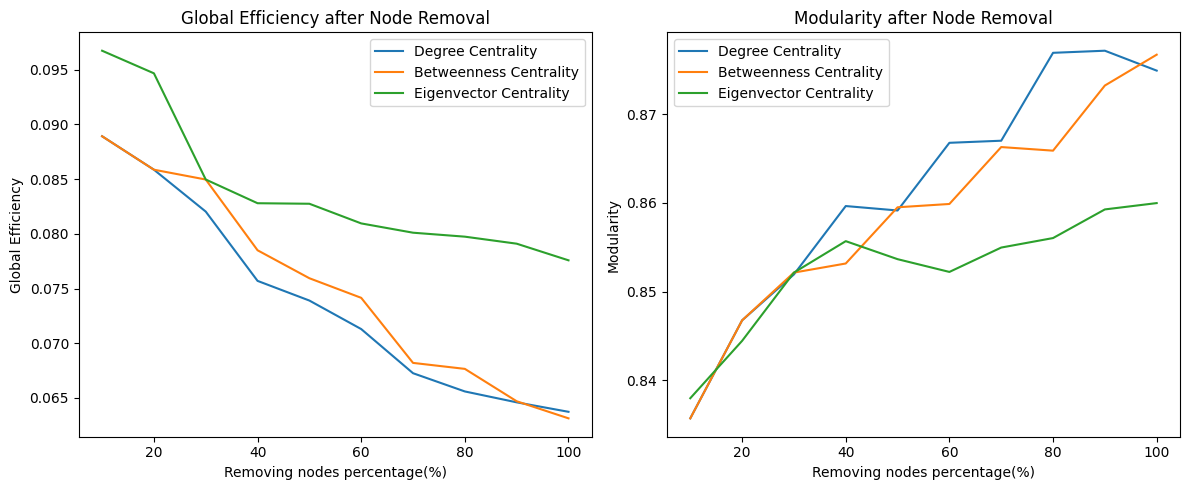

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Global efficiency 
ax[0].plot(degree['Removing nodes'], degree['Degree Global Efficiency'], label='Degree Centrality')
ax[0].plot(betweenness['Removing nodes'], betweenness['Betweenness Global Efficiency'], label='Betweenness Centrality')
ax[0].plot(eigenvector['Removing nodes'], eigenvector['Eigenvector Global Efficiency'], label='Eigenvector Centrality')
ax[0].set_xlabel('Removing nodes percentage(%)')
ax[0].set_ylabel('Global Efficiency')
ax[0].set_title('Global Efficiency after Node Removal')
ax[0].legend()

# Plot for Modularity
ax[1].plot(degree['Removing nodes'], degree['Degree Modularity'], label='Degree Centrality')
ax[1].plot(betweenness['Removing nodes'], betweenness['Betweenness Modularity'], label='Betweenness Centrality')
ax[1].plot(eigenvector['Removing nodes'], eigenvector['Eigenvector Modularity'], label='Eigenvector Centrality')
ax[1].set_xlabel('Removing nodes percentage(%)')
ax[1].set_ylabel('Modularity')
ax[1].set_title('Modularity after Node Removal')
ax[1].legend()

plt.tight_layout()
plt.show()

**Figure 2. The plot of Non-sequential node removal of two strageties**

In [17]:
df_nonseq = pd.concat([
    degree[['Degree Global Efficiency', 'Degree Modularity']],
    betweenness[['Betweenness Global Efficiency', 'Betweenness Modularity']],
    eigenvector[['Eigenvector Global Efficiency', 'Eigenvector Modularity']]
], axis=1)

# The 'Removing nodes' column should only be calculated once since the process is the same for all DataFrames
df_nonseq['Removing nodes Percentage'] = df_nonseq.index / 10 * 100

df_nonseq

,Degree Global Efficiency,Degree Modularity,Betweenness Global Efficiency,Betweenness Modularity,Eigenvector Global Efficiency,Eigenvector Modularity,Removing nodes Percentage
0,0.088917,0.835713,0.088917,0.835713,0.096735,0.837980,0.0
1,0.085862,0.846760,0.085862,0.846760,0.094668,0.844449,10.0
2,0.082033,0.851936,0.084963,0.852144,0.084963,0.852144,20.0
3,0.075700,0.859645,0.078498,0.853169,0.082797,0.855688,30.0
4,0.073903,0.859145,0.075942,0.859505,0.082749,0.853656,40.0
5,0.071298,0.866774,0.074152,0.859879,0.080953,0.852218,50.0
6,0.067264,0.867009,0.068206,0.866295,0.080104,0.854965,60.0
7,0.065596,0.876919,0.067660,0.865889,0.079741,0.856036,70.0
8,0.064602,0.877156,0.064700,0.873230,0.079100,0.859264,80.0
9,0.063736,0.874912,0.063139,0.876708,0.077579,0.859977,90.0


**Table 2.  The Table of Non-sequential node removal of two strageties**

##### b. sequential

**1. Prepare the centrality measures and DataFrames**

In [18]:
num_nodes_to_remove = 10

**2. Sequentially remove nodes and calculate metrics**

In [19]:
G = nx.read_graphml('london_updated.graphml')
G_seq_degree = G.copy()
results = []

for i in range(num_nodes_to_remove):
    # calculate the degree centrality of each node
    degree_centrality = nx.degree_centrality(G_seq_degree)
   
    # sort the dictionary by values in descending order
    sorted_degree = dict(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True))
    
    # get the first key in the dictionary
    node_to_remove = list(sorted_degree.keys())[0]
   
    # save the node's name and the degree centrality value of the node to remove
    centrality_value = sorted_degree[node_to_remove]
    
    # remove the node from the graph
    G_seq_degree.remove_node(node_to_remove)
    
    # calculate the global efficiency
    global_eff = nx.global_efficiency(G_seq_degree)
    
    # calculate the modularity
    communities = community.greedy_modularity_communities(G_seq_degree)
    modularity = community.modularity(G_seq_degree, communities)
 
    results.append({
        'Degree Removed Node': node_to_remove, 
        'Degree Centrality': centrality_value, 
        'Degree Global Efficiency': global_eff, 
        'Degree Modularity': modularity
        })

df_seq_degree = pd.DataFrame(results)

In [20]:
G = nx.read_graphml('london_updated.graphml')
G_seq_betweenness = G.copy()
results = []

for i in range(num_nodes_to_remove):
    # calculate the betweenness centrality of each node
    betweenness_centrality = nx.betweenness_centrality(G_seq_betweenness)
    
    # sort the dictionary by values in descending order
    sorted_betweenness = dict(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True))
    
    # get the first key in the dictionary
    node_to_remove = list(sorted_betweenness.keys())[0]

    # save the node's name and the betweenness centrality value of the node to remove
    centrality_value = sorted_betweenness[node_to_remove]
    
    # remove the node from the graph
    G_seq_betweenness.remove_node(node_to_remove)

    # calculate the global efficiency
    global_eff = nx.global_efficiency(G_seq_betweenness)

    # calculate the modularity
    communities = community.greedy_modularity_communities(G_seq_betweenness)
    modularity = community.modularity(G_seq_betweenness, communities)
 
    results.append({
        'Betweenness Removed Node': node_to_remove, 
        'Betweenness Centrality': centrality_value, 
        'Betweenness Global Efficiency': global_eff, 
        'Betweenness Modularity': modularity
        })

df_seq_betweenness = pd.DataFrame(results)

In [21]:
G = nx.read_graphml('london_updated.graphml')
G_seq_eigenvector = G.copy()
results = []

for i in range(num_nodes_to_remove):
    try:
        # Calculate eigenvector centrality
        eigenvector_centrality = nx.eigenvector_centrality(G_seq_eigenvector, max_iter=1000, tol=1e-06)
        # remove the node with the highest eigenvector centrality
        node_to_remove = max(eigenvector_centrality, key=eigenvector_centrality.get)
        centrality_value = eigenvector_centrality[node_to_remove]

        # remove the node from the graph
        G_seq_eigenvector.remove_node(node_to_remove)

        # calculate global efficiency
        global_eff = nx.global_efficiency(G_seq_eigenvector)

        # calculate modularity
        if G_seq_eigenvector.number_of_nodes() > 0:
            communities = community.greedy_modularity_communities(G_seq_eigenvector)
            modularity = community.modularity(G_seq_eigenvector, communities)
        else:
            modularity = None

        results.append({
            'Eigenvector Removed Node': node_to_remove,
            'Eigenvector Centrality': centrality_value,
            'Eigenvector Global Efficiency': global_eff,
            'Eigenvector Modularity': modularity
        })

    except nx.PowerIterationFailedConvergence as e:
        print(f"Convergence failed at iteration {i + 1}: {e}")
        break  # if the eigenvector centrality doesn't converge, stop the loop

df_seq_eigenvector = pd.DataFrame(results)

In [22]:
# Every graph has the same number of nodes, so we can use any of them to get the total number of nodes
total_nodes = len(G_seq_degree.nodes)  #get the total number of nodes

# combine the three DataFrames
df_seq = pd.concat([df_seq_degree, df_seq_betweenness, df_seq_eigenvector], axis=1)

# calculate the percentage of nodes removed
df_seq['Removing nodes Percentage'] = df_seq.index /10 * 100

# display the DataFrame
df_seq


,Degree Removed Node,Degree Centrality,Degree Global Efficiency,Degree Modularity,Betweenness Removed Node,Betweenness Centrality,Betweenness Global Efficiency,Betweenness Modularity,Eigenvector Removed Node,Eigenvector Centrality,Eigenvector Global Efficiency,Eigenvector Modularity,Removing nodes Percentage
0,Stratford,0.022500,0.088917,0.835713,Stratford,0.297846,0.088917,0.835713,Bank and Monument,0.383427,0.096735,0.837980,0.0
1,Bank and Monument,0.020050,0.085862,0.846760,King's Cross St. Pancras,0.247262,0.084603,0.845011,Oxford Circus,0.416543,0.095722,0.843009,10.0
2,Baker Street,0.017588,0.082033,0.851936,Waterloo,0.254180,0.081829,0.856455,Stratford,0.530685,0.084813,0.854950,20.0
3,King's Cross St. Pancras,0.017632,0.075700,0.859645,Bank and Monument,0.214651,0.077678,0.860751,Earl's Court,0.411513,0.083369,0.850647,30.0
4,Canning Town,0.015152,0.070396,0.866871,Canada Water,0.244903,0.072832,0.864249,Westminster,0.316724,0.082412,0.855686,40.0
5,Green Park,0.015190,0.069402,0.870024,West Hampstead,0.456831,0.053210,0.869824,Baker Street,0.427186,0.078219,0.860047,50.0
6,Earl's Court,0.015228,0.067772,0.870985,Earl's Court,0.096182,0.051656,0.871192,King's Cross St. Pancras,0.516549,0.072074,0.870394,60.0
7,Waterloo,0.012723,0.065936,0.872442,Shepherd's Bush,0.128852,0.045844,0.881066,Canning Town,0.530726,0.066899,0.872039,70.0
8,Oxford Circus,0.012755,0.065069,0.874393,Euston,0.087075,0.041631,0.881247,Turnham Green,0.538152,0.065458,0.876719,80.0
9,Willesden Junction,0.012788,0.056748,0.886262,Baker Street,0.098437,0.038164,0.887931,Leicester Square,0.420549,0.064080,0.879317,90.0


**Table 3. Sequential node removal of two strageties**

**3. Plot the global efficiency and modularity**

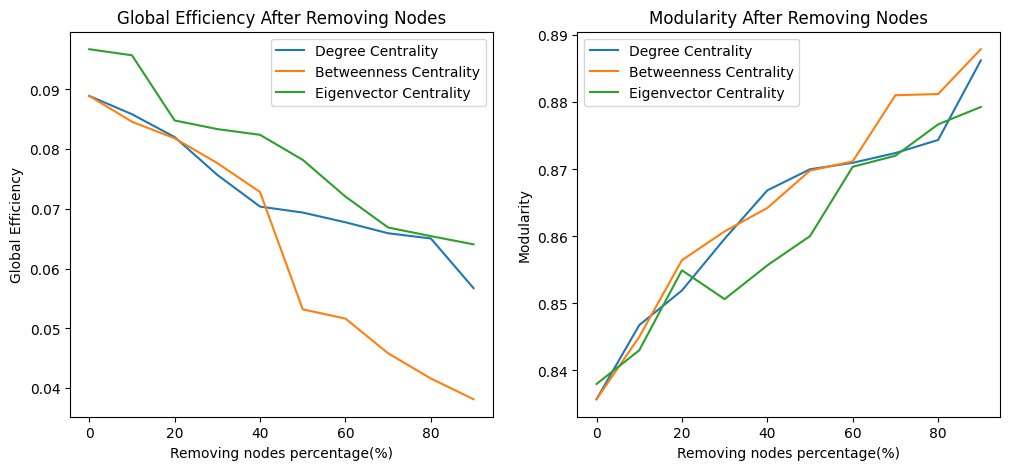

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# plot the global efficiency
ax[0].plot(df_seq['Removing nodes Percentage'], df_seq['Degree Global Efficiency'], label='Degree Centrality')
ax[0].plot(df_seq['Removing nodes Percentage'], df_seq['Betweenness Global Efficiency'], label='Betweenness Centrality')
ax[0].plot(df_seq['Removing nodes Percentage'], df_seq['Eigenvector Global Efficiency'], label='Eigenvector Centrality')
ax[0].set_xlabel('Removing nodes percentage(%)')
ax[0].set_ylabel('Global Efficiency')
ax[0].set_title('Global Efficiency After Removing Nodes')
ax[0].legend()

# plot the modularity
ax[1].plot(df_seq['Removing nodes Percentage'], df_seq['Degree Modularity'], label='Degree Centrality')
ax[1].plot(df_seq['Removing nodes Percentage'], df_seq['Betweenness Modularity'], label='Betweenness Centrality')
ax[1].plot(df_seq['Removing nodes Percentage'], df_seq['Eigenvector Modularity'], label='Eigenvector Centrality')
ax[1].set_xlabel('Removing nodes percentage(%)')
ax[1].set_ylabel('Modularity')
ax[1].set_title('Modularity After Removing Nodes')
ax[1].legend()

plt.show()

**Figure 3. The plot of Sequential node removal of two strageties**

**Combine the non-sequential and sequential Plot**

In [24]:
# Step 1: Rename the columns for non-sequential DataFrames
df_nonseq.columns = [f'Non-Sequential {col}' for col in df_nonseq.columns]

# Step 3: Rename the columns for the sequential DataFrame
df_seq.columns = [f'Sequential {col}' for col in df_seq.columns]

# Step 4: Combine the non-sequential and sequential DataFrames
DF_combined = pd.concat([df_nonseq, df_seq], axis=1)

DF_combined.head()

,Non-Sequential Degree Global Efficiency,Non-Sequential Degree Modularity,Non-Sequential Betweenness Global Efficiency,Non-Sequential Betweenness Modularity,Non-Sequential Eigenvector Global Efficiency,Non-Sequential Eigenvector Modularity,Non-Sequential Removing nodes Percentage,Sequential Degree Removed Node,Sequential Degree Centrality,Sequential Degree Global Efficiency,Sequential Degree Modularity,Sequential Betweenness Removed Node,Sequential Betweenness Centrality,Sequential Betweenness Global Efficiency,Sequential Betweenness Modularity,Sequential Eigenvector Removed Node,Sequential Eigenvector Centrality,Sequential Eigenvector Global Efficiency,Sequential Eigenvector Modularity,Sequential Removing nodes Percentage
0,0.088917,0.835713,0.088917,0.835713,0.096735,0.837980,0.0,Stratford,0.022500,0.088917,0.835713,Stratford,0.297846,0.088917,0.835713,Bank and Monument,0.383427,0.096735,0.837980,0.0
1,0.085862,0.846760,0.085862,0.846760,0.094668,0.844449,10.0,Bank and Monument,0.020050,0.085862,0.846760,King's Cross St. Pancras,0.247262,0.084603,0.845011,Oxford Circus,0.416543,0.095722,0.843009,10.0
2,0.082033,0.851936,0.084963,0.852144,0.084963,0.852144,20.0,Baker Street,0.017588,0.082033,0.851936,Waterloo,0.254180,0.081829,0.856455,Stratford,0.530685,0.084813,0.854950,20.0
3,0.075700,0.859645,0.078498,0.853169,0.082797,0.855688,30.0,King's Cross St. Pancras,0.017632,0.075700,0.859645,Bank and Monument,0.214651,0.077678,0.860751,Earl's Court,0.411513,0.083369,0.850647,30.0
4,0.073903,0.859145,0.075942,0.859505,0.082749,0.853656,40.0,Canning Town,0.015152,0.070396,0.866871,Canada Water,0.244903,0.072832,0.864249,Westminster,0.316724,0.082412,0.855686,40.0


**Table 4. The Combined Non-sequential and Sequential node removal of two strageties**

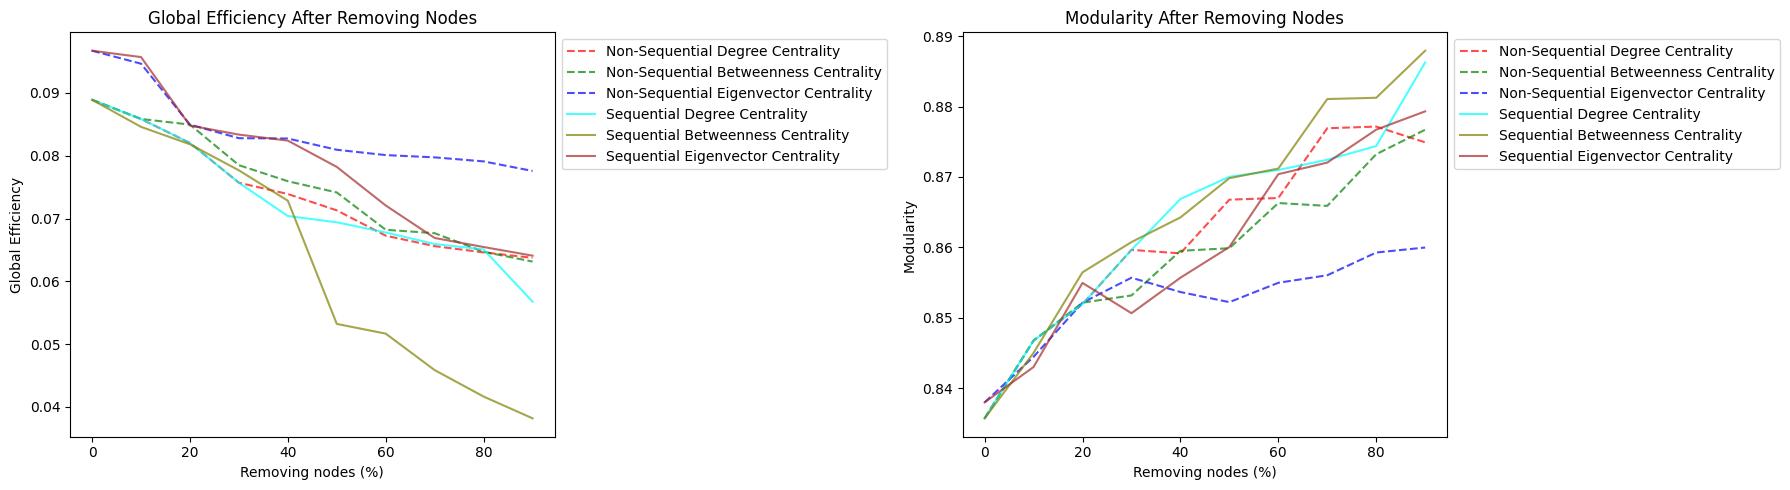

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot the global efficiency

# Non-Sequential
ax[0].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Degree Global Efficiency'], 
           label='Non-Sequential Degree Centrality', linestyle='--', color='red', alpha=0.7)
ax[0].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Betweenness Global Efficiency'], 
           label='Non-Sequential Betweenness Centrality', linestyle='--', color='green', alpha=0.7)
ax[0].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Eigenvector Global Efficiency'], 
           label='Non-Sequential Eigenvector Centrality', linestyle='--', color='blue', alpha=0.7)

# Sequential
ax[0].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Degree Global Efficiency'], 
           label='Sequential Degree Centrality', linestyle='-', color='cyan', alpha=0.7)
ax[0].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Betweenness Global Efficiency'], 
           label='Sequential Betweenness Centrality', linestyle='-', color='olive', alpha=0.7)
ax[0].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Eigenvector Global Efficiency'], 
           label='Sequential Eigenvector Centrality', linestyle='-', color='brown', alpha=0.7)

ax[0].set_xlabel('Removing nodes (%)')
ax[0].set_ylabel('Global Efficiency')
ax[0].set_title('Global Efficiency After Removing Nodes')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# plot the modularity

# Non-Sequential
ax[1].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Degree Modularity'], 
           label='Non-Sequential Degree Centrality', linestyle='--', color='red', alpha=0.7)
ax[1].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Betweenness Modularity'],
            label='Non-Sequential Betweenness Centrality', linestyle='--', color='green', alpha=0.7)
ax[1].plot(DF_combined['Non-Sequential Removing nodes Percentage'], DF_combined['Non-Sequential Eigenvector Modularity'],
            label='Non-Sequential Eigenvector Centrality', linestyle='--', color='blue', alpha=0.7)

# Sequential
ax[1].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Degree Modularity'],
            label='Sequential Degree Centrality', linestyle='-', color='cyan', alpha=0.7)
ax[1].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Betweenness Modularity'],
            label='Sequential Betweenness Centrality', linestyle='-', color='olive', alpha=0.7)
ax[1].plot(DF_combined['Sequential Removing nodes Percentage'], DF_combined['Sequential Eigenvector Modularity'],
            label='Sequential Eigenvector Centrality', linestyle='-', color='brown', alpha=0.7)

ax[1].set_xlabel('Removing nodes (%)')
ax[1].set_ylabel('Modularity')
ax[1].set_title('Modularity After Removing Nodes')
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust the layout so the legend fits without overlapping the plot
plt.show()

**Figure 4. Comparision of Non-sequential and Sequential Node Removal of Two Strageties**

##### **Strategies for Studying resilience**
Comparing the two strategies, the **sequential removal** is more realistic to the real life situation as the network efficiency should be recaluculated each time after the node removal(attack). As shown in the two plots, they reveal the same situation, where the sequential removal would give greater impact on the network system(global efficiency drop more for sequential than for non-sequential; modularity increase higher for sequential and for non-sequential), as the recalculation would put the existing top one important node into the next round of node removal.

##### **Centrality Measure**
It is appeared that eigenvector change the least among the three centrality measures, while betweenness centrality measure is the most sensitive to the node removal for both removal patterns. **Betweenness Centrality**, the larger drop in global efficiency when nodes are removed based on betweenness centrality suggests that these nodes may play a more critical role in the flow through the network. These stations likely act as important bridges in the network, and their removal can significantly impact overall travel efficiency.

##### **Impact measure for assessing damage**
In terms of two removal strategies, from the plots shown in figure 3, both work very well, but in the case of examing the impact of node removal, **global efficiency** is a better choice compare to modularity as the modularity has this up and down changing pattern which could lead to confusion in the practice (global efficiency is changing in one direction).

### II. Flows: weighted network

#### II.1. Define flow and the Top 10 nodes

In [26]:
G = nx.read_graphml('london_updated.graphml')
G_weighted = G.copy()
# To check edge attributes:
#G.edges(data=True)

To consider the weighted network in the Underground, a weighted parameter "flows" and "length" can be used for the weighted network. I am going to use both since taking passengers into consideration can both relates to the traveling time (length/distance between the stations) and the commuting population density (flows). They are both important parameters when stations are removed.

Compare the weighted results to the the topological results, the top 10 stations are semi-different. 

In [27]:
# computing the degree centrality
weighted_degree_centrality = {}
for node in G_weighted.nodes():
    weighted_degree = sum(weight for _, _, weight in G_weighted.edges(node, data='length'))
    weighted_degree_centrality[node] = weighted_degree

# computing the betweenness centrality
weighted_betweenness_centrality = nx.betweenness_centrality(G_weighted, weight='length')

# computing the eigenvector centrality
weighted_eigenvector_centrality = nx.eigenvector_centrality_numpy(G_weighted, weight='length')

In [28]:
# Sorting and selecting top 10
sorted_degree = sorted(weighted_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_betweenness = sorted(weighted_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_eigenvector = sorted(weighted_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create DataFrame from sorted lists
combined_weighted_df = pd.DataFrame({
    'Rank': range(1, 11),
    'Degree Centrality Station': [x[0] for x in sorted_degree],
    'Degree Centrality Value': [x[1] for x in sorted_degree],
    'Betweenness Centrality Station': [x[0] for x in sorted_betweenness],
    'Betweenness Centrality Value': [x[1] for x in sorted_betweenness],
    'Eigenvector Centrality Station': [x[0] for x in sorted_eigenvector],
    'Eigenvector Centrality Value': [x[1] for x in sorted_eigenvector]
}).set_index('Rank')

# Display the DataFrame
display(combined_weighted_df)

,Degree Centrality Station,Degree Centrality Value,Betweenness Centrality Station,Betweenness Centrality Value,Eigenvector Centrality Station,Eigenvector Centrality Value
Rank,,,,,,
1,Stratford,18809.755024,Bank and Monument,0.221504,Wembley Park,0.640161
2,Wembley Park,13955.803937,King's Cross St. Pancras,0.209674,Finchley Road,0.635998
3,Chalfont & Latimer,13214.405571,Stratford,0.182494,Baker Street,0.287363
4,Finchley Road,12201.911381,Baker Street,0.164248,Kingsbury,0.210939
5,Liverpool Street,12070.083236,Oxford Circus,0.157306,Neasden,0.168126
6,Willesden Junction,11100.258775,Euston,0.155138,Preston Road,0.104587
7,Baker Street,10613.160373,Earl's Court,0.143521,St. John's Wood,0.073800
8,King's Cross St. Pancras,10453.003671,Shadwell,0.139449,Bond Street,0.057430
9,Bank and Monument,9383.512648,Waterloo,0.130213,West Hampstead,0.054723


**Table 5. Top 10 Stations for a Weighted(length/distance) Tube Network**

In [29]:
# computing the degree centrality
weighted_degree_centrality = {}
for node in G_weighted.nodes():
    weighted_degree = sum(weight for _, _, weight in G_weighted.edges(node, data='flows'))
    weighted_degree_centrality[node] = weighted_degree

# computing the betweenness centrality
weighted_betweenness_centrality = nx.betweenness_centrality(G_weighted, weight='flows')

# computing the eigenvector centrality
weighted_eigenvector_centrality = nx.eigenvector_centrality_numpy(G_weighted, weight='flows')

In [30]:
# Sorting and selecting top 10
sorted_degree = sorted(weighted_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_betweenness = sorted(weighted_betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_eigenvector = sorted(weighted_eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create DataFrame from sorted lists
combined_weighted_df = pd.DataFrame({
    'Rank': range(1, 11),
    'Degree Centrality Station': [x[0] for x in sorted_degree],
    'Degree Centrality Value': [x[1] for x in sorted_degree],
    'Betweenness Centrality Station': [x[0] for x in sorted_betweenness],
    'Betweenness Centrality Value': [x[1] for x in sorted_betweenness],
    'Eigenvector Centrality Station': [x[0] for x in sorted_eigenvector],
    'Eigenvector Centrality Value': [x[1] for x in sorted_eigenvector]
}).set_index('Rank')

# Display the DataFrame
display(combined_weighted_df)

,Degree Centrality Station,Degree Centrality Value,Betweenness Centrality Station,Betweenness Centrality Value,Eigenvector Centrality Station,Eigenvector Centrality Value
Rank,,,,,,
1,Green Park,713696,West Hampstead,0.396617,Green Park,0.527545
2,Bank and Monument,583541,Gospel Oak,0.295238,Westminster,0.495329
3,Waterloo,570862,Finchley Road & Frognal,0.285821,Waterloo,0.416148
4,King's Cross St. Pancras,483565,Hampstead Heath,0.284978,Bank and Monument,0.286512
5,Westminster,461343,Willesden Junction,0.267440,Victoria,0.279919
6,Liverpool Street,437335,Stratford,0.261758,Oxford Circus,0.202460
7,Victoria,383024,Brondesbury,0.243142,Bond Street,0.194256
8,Euston,374576,Brondesbury Park,0.241667,Liverpool Street,0.143603
9,Stratford,366679,Kensal Rise,0.240204,Southwark,0.076285


**Table 6. Top 10 Stations for a Weighted (flows) Tube Network**

Comparing the two tables above, it shows that when taking different weights into consideration can lead to quite different results. 

#### II.2.

Global Efficiency and modularity are enough for examing the weighted network as the former one can be used for accessing "distance(length)" as the weight while the latter one be used for accessing "population(flows)" as the weight.

The **weighted global efficiency** is a measure of efficiency in a network, which is often used to quantify the efficiency of information or material flows between nodes in the network. The weights (weight) represent distances (distance) in this context, which means higher weights indicate larger distances, and hence, lower efficiency.

Definition:
Given a weighted graph, the global efficiency $E_{glob}$ is defined as the average inverse weighted shortest path length between each pair of nodes. For any two nodes $u$ and $v$, the efficiency $e(u, v)$ is given by $e(u, v) = \frac{1}{d(u,v)}$, where $d(u,v)$ is the shortest weighted path length between nodes (weight).

Formula:
$$E_{glob} = \frac{1}{N(N-1)} \sum_{u,v \in V, u \neq v} \frac{1}{d(u,v)}$$
Here, $N$ is the total number of nodes, $V$ is the set of nodes, and $d(u, v)$ is the weighted shortest path length between the nodes $u$ and $v$ (considering weights as distances).


In [31]:
G_weighted = G.copy()

def weighted_global_efficiency(G, node_all=None):
    """计算带权重的全局效率"""
    n = len(G)
    if n <= 1:
        return 0  # 如果图中只有一个或没有节点，全局效率为0

    if node_all is None:
        node_all = n

    dist_sum = 0
    path_count = 0
    # 使用 Dijkstra 算法计算所有节点对之间的最短路径长度
    for lengths in nx.all_pairs_dijkstra_path_length(G, weight='distance'):
        for target, dist in lengths[1].items(): 
            if  dist >0:
                # 只有当源节点和目标节点不同时，才计算效率
                dist_sum += 1 / dist
                path_count += 1

    # 如果有有效的路径对，计算平均全局效率；否则返回0
    if node_all > 1:
        return dist_sum / ((node_all * (node_all - 1)) / 2)
    else:
        return 0

# 调用函数计算全局效率
original_total_nodes = len(G_weighted)
global_eff = weighted_global_efficiency(G_weighted, node_all=original_total_nodes)
print("Weighted Global Efficiency:", global_eff)

Weighted Global Efficiency: 0.20251238719443027


For **weighted modularity**, a high modularity value indicates that the network can be clearly classified into modules or communities consisting of densely connected nodes internally. When calculating modularity, the weight parameter is used to indicate the importance of edges, such as traffic, capacity, etc., and in this case population flows, which helps to determine which connections are more critical to the community structure.

In [32]:
G_weighted = G.copy()

communities = community.greedy_modularity_communities(G_weighted, weight='flows')

modularity = community.modularity(G_weighted, communities, weight='flows')
print(f"Modularity is: {modularity}")

Modularity is: 0.7321343579048248


#### II.3. Remove the 3 highest ranked  nodes

**Using betweenness centrality:**

In [33]:
G_BC = G.copy()
G_BC.nodes(data=True)
node_name = "Bank and Monument"
G_BC.remove_node(node_name)
# calculate the global efficiency
global_eff = weighted_global_efficiency(G_BC, node_all=original_total_nodes)
# calculate the modularity
communities = community.greedy_modularity_communities(G_BC, weight='flows')
modularity = community.modularity(G_BC, communities, weight='flows')
print({'Removed Node': node_name, 
                'Global Efficiency': global_eff, 
                'Modularity': modularity})

{'Removed Node': 'Bank and Monument', 'Global Efficiency': 0.19250457694682765, 'Modularity': 0.7686870265089242}


In [34]:
G_nonseq_removal_weighted = G.copy()

In [35]:
betweenness = nx.betweenness_centrality(G, weight='length') 

# 将结果转换为DataFrame
weighted_centrality_df = pd.DataFrame(list(betweenness.items()), columns=['Station', 'betweenness_centrality'])

# 对介数中心性进行降序排序，并取前三个站点的名称
top_3_betweenness = weighted_centrality_df.sort_values(by='betweenness_centrality', ascending=False)['Station'][:3].tolist()

In [36]:
G_nonseq_removal_weighted = G.copy()
# prepare the dataframe to store the results
results = []

remove_list = top_3_betweenness

for node_name in remove_list:
    # remove the node from the graph
    G_nonseq_removal_weighted.remove_node(node_name)
    # calculate the global efficiency
    global_eff = weighted_global_efficiency(G_nonseq_removal_weighted, node_all=original_total_nodes)
    # calculate the modularity
    communities = community.greedy_modularity_communities(G_nonseq_removal_weighted, weight='flows')
    modularity = community.modularity(G_nonseq_removal_weighted, communities, weight='flows')
    # save the results to the dataframe
    results.append({'Removed Node': node_name, 
                    'Global Efficiency': global_eff, 
                    'Modularity': modularity})
df_nonseq_betweenness_weighted = pd.DataFrame(results)

In [37]:
G_seq_removal_weighted = G.copy()
results = []

#remove the top one betweenness centrality node
for i in range(3):
    # calculate the betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G_seq_removal_weighted, weight='length')
    # sort the dictionary by values in descending order
    sorted_betweenness = dict(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True))
    # get the first key in the dictionary
    node_to_remove = list(sorted_betweenness.keys())[0]
    # remove the node from the graph
    G_seq_removal_weighted.remove_node(node_to_remove)
    # calculate the global efficiency
    global_eff = weighted_global_efficiency(G_seq_removal_weighted, node_all=original_total_nodes)
    # calculate the modularity
    communities = community.greedy_modularity_communities(G_seq_removal_weighted, weight='flows')
    modularity = community.modularity(G_seq_removal_weighted, communities, weight='flows')
    results.append({'Removed Node': node_to_remove, 
                    'Global Efficiency': global_eff, 
                    'Modularity': modularity})
df_seq_betweenness_weighted = pd.DataFrame(results)

In [38]:
#combine the dataframe
DF_combined_weighted = pd.concat([df_nonseq_betweenness_weighted, df_seq_betweenness_weighted], axis=1)
new_columns = [
    'Removed Node Nonsequential', 'Global Efficiency Nonsequential', 'Modularity Nonsequential',
    'Removed Node Sequential', 'Global Efficiency Sequential', 'Modularity Sequential'
]
DF_combined_weighted.columns = new_columns
DF_combined_weighted

,Removed Node Nonsequential,Global Efficiency Nonsequential,Modularity Nonsequential,Removed Node Sequential,Global Efficiency Sequential,Modularity Sequential
0,Bank and Monument,0.192505,0.768687,Bank and Monument,0.192505,0.768687
1,King's Cross St. Pancras,0.177976,0.787755,King's Cross St. Pancras,0.177976,0.787755
2,Stratford,0.158177,0.798175,Canada Water,0.163636,0.790404


**Table 7. Top 3 Stations for a Weighted Tube Network**

Non sequential seems to be slightly more damaged than the sequential way after the third removal while surprisingly stay the same in the first two removals. Therefore, Bank and Monument Station and St.Pancras Station and Stratford Station are the three most important stations in the tube network. 

## Part 2: Spatial Interaction models

### III. Models and calibration

#### III.1. Model Definition

There is a famility of spatial interaction model that shows different sptial interaction patterns: 

**1. The Unconstrained Model**
The model describes the proportionality of the product of the mass of the origin and destination and the inversley proportional to the distance between them. 
\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

Wilson's version (1971) of the family of gravity models:
\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}


$T_{ij}$：The flows from the origin station $i$ to the destination station $j$.

$O_{i}$: The origion station $i$ 's population.

$D_{j}$: The destination station $j$ 's attractivness(jobs).

$d_{ij}$: The cost or distance from station $i$ to $j$. 

$K$: The model parameters, or calibration constant.

$\beta$: distance decay parameter.




**2. The Singly-Constrained Model** 

It is usually used in the constomer transport behavior analysis. Constrain one parameter. 
 
 <b>Production (orign) Constrained Spatial Interaction Model</b>



 $\begin{equation}\tag{3}
      T_{ij} = A_i O_i D_j \exp(-\beta c_{ij}) \quad \text{subject to} \quad \sum_{j=1}^{m} T_{ij} = O_i
    \end{equation}$
 $A_{i}$:Attractiveness of the destination.

 <b>Attraction (destination) Constrained Spatial Interaction Model</b>

 $\begin{equation}\tag{4}
      T_{ij} = B_j O_i D_j \exp(-\beta c_{ij}) \quad \text{subject to} \quad \sum_{i=1}^{n} T_{ij} = D_j
    \end{equation}$

$B_{j}$: A scaling paprameter for alignment of origin $i$.

**3. The Doubly-Costrained Model**

It is a comprehensive model udapted from the singly-constrained model, where it sets both the origins and the destinations in the model as the fixed constrains. 

$\begin{equation}\tag{5}
    T_{ij} = A_i O_i B_j D_j \exp(-\beta c_{ij}) \quad \text{subject to} \quad \sum_{j=1}^{m} T_{ij} = O_i \quad \text{and} \quad \sum_{i=1}^{n} T_{ij} = D_j
\end{equation}$

#### III.2. Model Calibration

Use singly-constrained model because we interested in the flows depend on the population(fixed) and the jobs/attractiveness of the places(not fixed) in the destination would be better suited for the scenario testing where one parameter is fixed and the other is not.

We need to make the model as accurately predict the actually flow as possible.



The rest of the notebook is some thinking process as I don't really understand the concept, so the rest of the codes are just the prove that I tried...

In [3]:
# import all the necessary libraries
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit  
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
from math import sqrt
import statsmodels.formula.api as smf
from scipy.stats import norm
import networkx as nx

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\2158460682.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df = pd.read_csv('London_flows.csv')
df.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


**Table 8. London Flows**

**Data Preprocessing**

In [5]:
#(drop the rows that is zero and in this case drop Battersea Park as it has no data for the flows)
df_drop = df[df['flows'] != 0]
df_drop.head()

,station_origin,station_destination,flows,population,jobs,distance
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560


**Table 9. London Flows Revised**

**Log**

In [6]:
df_drop['flow'] = df_drop['flows']
df_drop['log_flow'] = np.log(df_drop['flow'])
df_drop['dist'] = df_drop['distance'] + 1e-6 + 1
df_drop['log_dist'] = np.log(df_drop['dist'])
df_drop['log_jobs'] = np.log(df_drop['jobs'])
df_origin = df_drop.copy()
df_drop.head()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\4050372465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop['flow'] = df_drop['flows']
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\4050372465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop['log_flow'] = np.log(df_drop['flow'])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\4050372465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs
1,Abbey Road,Beckton,1,599,442,8510.121774,1,0.000000,8511.121775,9.049129,6.091310
2,Abbey Road,Blackwall,3,599,665,3775.448872,3,1.098612,3776.448873,8.236539,6.499787
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.000000,5087.514221,8.534545,10.981421
4,Abbey Road,Canning Town,37,599,15428,2228.923167,37,3.610918,2229.923168,7.709722,9.643939
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,0.000000,6687.475561,8.807992,7.096721


**Table 10. London Flows Logged**

In [7]:
print("variance of flows: ", df_origin['flows'].var())
print("variance of log_flow: ", df_origin['log_flow'].var())

variance of flows:  23804.54155601981
variance of log_flow:  2.55093809831381


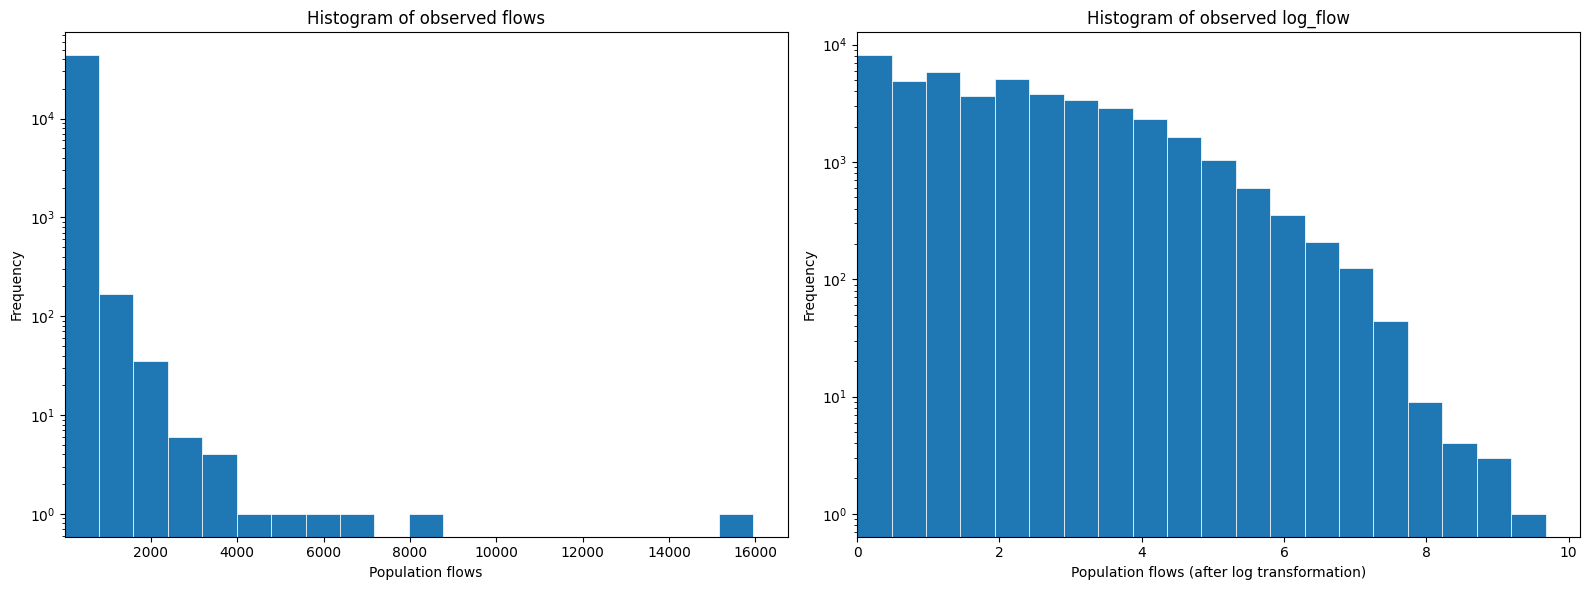

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))  # 1行2列的子图，整体图形大小为16x6

axes[0].hist(df_origin['flows'], bins=20, edgecolor='white', linewidth=0.5)
axes[0].set_title('Histogram of observed flows')
axes[0].set_yscale('log')
axes[0].set_xlabel('Population flows')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(left=1) 

axes[1].hist(df_origin['log_flow'], bins=20, edgecolor='white', linewidth=0.5)
axes[1].set_title('Histogram of observed log_flow')
axes[1].set_yscale('log')
axes[1].set_xlabel('Population flows (after log transformation)')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(left=0)  

plt.tight_layout()  
plt.show()

Figure 5. Traffic Flows Histograms of flows and logged flows

The histograms above shows that the flows is like a power-law distribution.

**Plot the log-log Flow Plot**

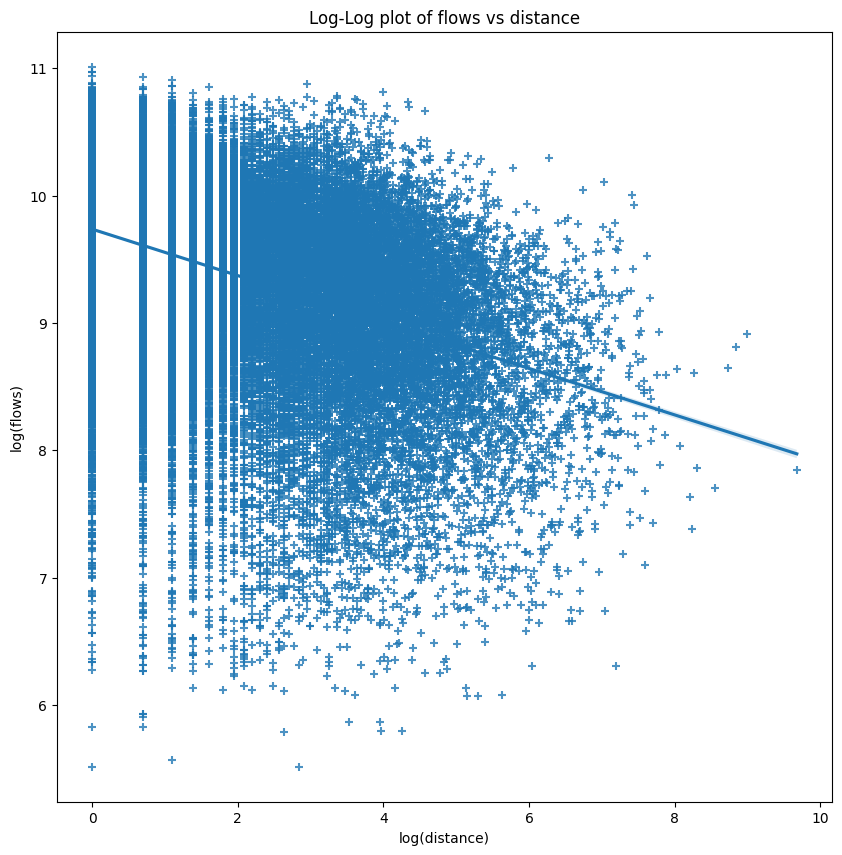

In [11]:
#subset the dataframe to the flows we want
cdata_flows = df_origin[["flows", "distance"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["flows"])
y = np.log(cdata_flows["distance"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))

#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)

# set the title
ax.set_title("Log-Log plot of flows vs distance")
ax.set_xlabel("log(distance)")
ax.set_ylabel("log(flows)")
plt.show()

**Figure 5. Log-log Plot of Flows vs Distance**

In [20]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flow ~ station_origin + log_jobs + log_dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=df_drop, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   flow   No. Observations:                43952
Model:                            GLM   Df Residuals:                    43552
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0249e+06
Date:                Mon, 29 Apr 2024   Deviance:                   1.8776e+06
Time:                        17:19:15   Pearson chi2:                 2.98e+06
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

The $\gamma$ parameter related to the destination attractiveness: 0.7378

The $\beta$ distance decay parameter: -0.3672. 

P value shows all the explainatory variables are statistically significant <0.01. The z score indicates that the jobs have the most influence on the model.

In [21]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(df_drop.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
df_drop = df_drop.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(df_drop.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
df_drop = df_drop.merge(D_j, on = "station_destination", how = "left" )

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\2847122089.py:3: FutureWarning: The provided callable <function sum at 0x000002137F7B09A0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  O_i = pd.DataFrame(df_drop.groupby(["station_origin"])["flows"].agg(np.sum))
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\2847122089.py:7: FutureWarning: The provided callable <function sum at 0x000002137F7B09A0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  D_j = pd.DataFrame(df_drop.groupby(["station_destination"])["flows"].agg(np.sum))


In [22]:
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "",regex=True)
coefs
df_drop = df_drop.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
df_drop.drop(columns = ["coef"], inplace = True)
df_drop.head()

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,O_i,D_j,alpha_i
0,Abbey Road,Beckton,1,599,442,8510.121774,1,0.000000,8511.121775,9.049129,6.091310,599,442,-0.21832
1,Abbey Road,Blackwall,3,599,665,3775.448872,3,1.098612,3776.448873,8.236539,6.499787,599,665,-0.21832
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.000000,5087.514221,8.534545,10.981421,599,58772,-0.21832
3,Abbey Road,Canning Town,37,599,15428,2228.923167,37,3.610918,2229.923168,7.709722,9.643939,599,15428,-0.21832
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,0.000000,6687.475561,8.807992,7.096721,599,1208,-0.21832


In [24]:
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\1887813951.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodSim.params[-2]
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15608\1887813951.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = -prodSim.params[-1]


In [25]:
df_drop["prodsimest1"] = np.exp(df_drop["alpha_i"]+gamma*df_drop["log_jobs"] 
                                 - beta*df_drop["log_dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
df_drop.head(10)

,station_origin,station_destination,flows,population,jobs,distance,flow,log_flow,dist,log_dist,log_jobs,O_i,D_j,alpha_i,prodsimest1
0,Abbey Road,Beckton,1,599,442,8510.121774,1,0.000000,8511.121775,9.049129,6.091310,599,442,-0.21832,2.592975
1,Abbey Road,Blackwall,3,599,665,3775.448872,3,1.098612,3776.448873,8.236539,6.499787,599,665,-0.21832,4.723642
2,Abbey Road,Canary Wharf,1,599,58772,5086.514220,1,0.000000,5087.514221,8.534545,10.981421,599,58772,-0.21832,115.548339
3,Abbey Road,Canning Town,37,599,15428,2228.923167,37,3.610918,2229.923168,7.709722,9.643939,599,15428,-0.21832,58.310923
4,Abbey Road,Crossharbour,1,599,1208,6686.475560,1,0.000000,6687.475561,8.807992,7.096721,599,1208,-0.21832,5.948552
5,Abbey Road,Cutty Sark,2,599,1748,8503.898909,2,0.693147,8504.898910,9.048398,7.466228,599,1748,-0.21832,7.152677
6,Abbey Road,Cyprus,7,599,850,6532.099618,7,1.945910,6533.099619,8.784637,6.745236,599,850,-0.21832,4.629269
7,Abbey Road,Devons Road,1,599,611,3958.324171,1,0.000000,3959.324172,8.283829,6.415097,599,611,-0.21832,4.361126
8,Abbey Road,East India,2,599,1522,3384.141666,2,0.693147,3385.141667,8.127151,7.327781,599,1522,-0.21832,9.057944
9,Abbey Road,Island Gardens,2,599,691,7706.296370,2,0.693147,7707.296371,8.949923,6.538140,599,691,-0.21832,3.739332


**Assessing the model output**

To test the "Goodness-of-fit" of the model, check the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). 

In [45]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

In [46]:
def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

Let's use poisson regression to test which model can get the best result:

Flow - Distance:

In [47]:
best2_formula_double_sim_exp = "flow ~ station_origin + log_jobs + dist-1"

best2_double_sim_exp = smf.glm(formula=best2_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(df_origin["flow"], best2_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], best2_double_sim_exp.mu))

R-squared:  0.45590488914083815
RMSE:  114.37


Flow - Logged distance:

In [48]:
formula_double_sim_exp = "flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

print("R-squared: ", CalcRSqaured(df_origin["flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["flow"], double_sim_exp.mu))

R-squared:  0.1683779372123963
RMSE:  152.287


**Logged flow - distance:**

In [49]:
best_formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + dist-1"

best_double_sim_exp = smf.glm(formula=best_formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print
print("R-squared: ", CalcRSqaured(df_origin["log_flow"], best_double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], best_double_sim_exp.mu))

R-squared:  0.5387247573433747
RMSE:  1.088


**The r square is the biggest and the RMSE is the smallest, therefore this combination has the best performance.**

Logged flow - logged distance:

In [50]:
formula_double_sim_exp = "log_flow ~ station_origin + log_jobs + log_dist-1"

double_sim_exp = smf.glm(formula=formula_double_sim_exp, data=df_origin, family=sm.families.Poisson()).fit()

# print
print("R-squared: ", CalcRSqaured(df_origin["log_flow"], double_sim_exp.mu))
print("RMSE: ", CalcRMSE(df_origin["log_flow"], double_sim_exp.mu))

R-squared:  0.30449397993579636
RMSE:  1.44


### IV. Scenarios

#### IV.1. Scenario A: Job Decrease

 Cut half of the jobs in Canary  Wharf while conserving the number of people commuting: 

#### IV.2. Scenario B: Travel Cost Increase

Increase in travel cost can lead to decrease in the population parameter:
I don't know how to calculate it.

#### IV.3. Discussion

## Reference

Berche, B., C. von Ferber, T. Holovatch, and Yu. Holovatch. 2009. “Resilience of Public
Transport Networks against Attacks.” The European Physical Journal B 71 (1): 125–37.
https://doi.org/10.1140/epjb/e2009-00291-3.

Bloch, Francis, Matthew O. Jackson, and Pietro Tebaldi. 2019. “Centrality Measures in Networks.” SSRN Scholarly Paper ID 2749124. Rochester, NY: Social Science Research Network. https://doi.org/10.2139/ssrn.2749124

Bonacich, Phillip. 1987. “Power and Centrality: A Family of Measures.” American Journal of
Sociology 92 (5): 1170–82. https://doi.org/10.1086/228631.

Dijkstra, E.W. (1959). A note on two problems in connexion with graphs. Numer. Math. 1, 269–271 . https://doi.org/10.1007/BF01386390

Freeman, L. (1977): “A set of measures of centrality based on betweenness,” Sociometry,
40(1), 35–41.

Latora, Vito, and Massimo Marchiori. “Efficient behavior of small-world networks.” Physical Review Letters 87.19 (2001): 198701. <https://doi.org/10.1103/PhysRevLett.87.198701>

Nguyen, Quang & Khanh, Nguyen & Cassi, Davide & Bellingeri, Michele. (2021). New Betweenness Centrality Node Attack Strategies for Real-World Complex Weighted Networks.
Complexity. 2021. <https://doi.org/10.1155/2021/1677445.>

Wilson, A. G. (1971). ‘A Family of Spatial Interaction Models, and Associated 
Developments’. Environment and Planning A: Economy and Space. SAGE Publications Ltd, 
3 (1), pp. 1–32. doi: 10.1068/a030001.   